In [1]:
import importlib 
import util, models, training

importlib.reload(util)
importlib.reload(models)
importlib.reload(training)

<module 'training' from '/home/unix/hschluet/projects/pt-pbmc/training.py'>

In [2]:
from data import PlateDataset
from util import torch_random_choice
from models import GatedAttentionMulti, GatedAttention
from training import train_model

import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns
import umap


device = 'cuda:6'

In [3]:
data = PlateDataset([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], load_masks=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.81it/s]


In [4]:
data.info

,plate,well,series,cell,patient,time,qc,group
0,1,A02,0,25,H01,0,True,healthy
1,1,A02,0,30,H01,0,True,healthy
2,1,A02,0,37,H01,0,True,healthy
3,1,A02,0,43,H01,0,True,healthy
4,1,A02,0,44,H01,0,True,healthy
...,...,...,...,...,...,...,...,...
1093961,16,H12,9,565,H15,0,True,healthy
1093962,16,H12,9,569,H15,0,True,healthy
1093963,16,H12,9,570,H15,0,True,healthy
1093964,16,H12,9,572,H15,0,True,healthy


In [5]:
cdf = data.info.groupby(['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H09', 'H10',
       'H13', 'H15', 'H16', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23',
       'H24', 'H25', 'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36',
       'H37', 'H39', 'H40', 'H43', 'H45', 'H47', 'H48', 'H49', 'P102',
       'P103', 'P104', 'P105', 'P106', 'P107', 'P109', 'P11', 'P110',
       'P111', 'P112', 'P113', 'P114', 'P115', 'P116', 'P117', 'P118',
       'P119', 'P120', 'P121', 'P123', 'P124', 'P125', 'P126', 'P127',
       'P128', 'P129', 'P13', 'P130', 'P131', 'P132', 'P134', 'P135',
       'P136', 'P137', 'P138', 'P139', 'P14', 'P140', 'P142', 'P143',
       'P144', 'P145', 'P146', 'P147', 'P148', 'P149', 'P15', 'P150',
       'P151', 'P152', 'P154', 'P155', 'P156', 'P158', 'P159', 'P16',
       'P160', 'P161', 'P162', 'P163', 'P164', 'P165', 'P166', 'P167',
       'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P27', 'P28', 'P29', 'P30', 'P32', 'P33', 'P34', 'P35', 'P37',
       'P38', 'P

In [6]:
use_plates = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [7]:
def healthy_vs_cancer_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['time'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_healthy = pat_groups[0]
  pat_cancer = pat_groups[1]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  while True:
    label = np.random.randint(2)
    pat = np.random.choice(pat_healthy if label == 1 else pat_cancer)
    xs = use_data[torch_random_choice(pat_lut[pat], size=bag_size)]
    yield xs.float(), torch.tensor(label).to(device)


def test_healthy_vs_cancer_bagloader(bag_size=50, reps=5, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device,
                                      transform=T.CenterCrop(28), return_chrometric=False, return_masks=False):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  if return_masks:
    use_masks = transform(data.masks[use_idx].to(device))
  if return_chrometric:
    use_chrometric = data.chrometrics.iloc[use_idx].reset_index()
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    for _ in range(reps):
      idx = torch_random_choice(pat_idx, size=bag_size)
      xs = use_data[idx]
      label = 1 if pat[0] == 'H' else 0
      if not return_chrometric and return_masks:
        yield xs.float(), use_masks[idx], torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'
      elif not return_chrometric and not return_masks:
        yield xs.float(), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'
      elif return_chrometric and return_masks:
        yield xs.float(), use_masks[idx], torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer', use_chrometric.iloc[idx.cpu().numpy()]
      else:
        yield xs.float(), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer', use_chrometric.iloc[idx.cpu().numpy()]

In [8]:
def eval_model(classifier_name, loader, branches=5, classes=1, return_masks=False):
    if classes > 1:
      classifier = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      classifier = GatedAttention(branches=branches)
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{classifier_name}_model.pt', weights_only=True, map_location=device))
    classifier.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    masks = []
    for i, (bag, mask, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = classifier(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())
        masks.extend(mask.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn
    return df, bag_zs, bags, masks


def eval_model_with_chrometrics(classifier_name, loader, branches=5, classes=1):
    if classes > 1:
      classifier = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      classifier = GatedAttention(branches=branches)
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{classifier_name}_model.pt', weights_only=True, map_location=device))
    classifier.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    chrometrics = []
    masks = []
    for i, (bag, mask, lab, pat, group, cs) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = classifier(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())
        masks.extend(mask.cpu().numpy())
        chrometrics.append(cs)

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn

    chrometrics = pd.concat(chrometrics, ignore_index=True)
    return df, bag_zs, bags, masks, chrometrics

In [9]:
pat_plates = data.info.groupby('plate')['patient'].unique()
pat_plates

plate
1     [H01, P51, H04, P57, P132, P46, P47, P108, P68...
2     [P116, H05, P15, P124, P52, P22, P29, P16, P10...
3     [P115, P72, P50, P67, P100, H06, P77, P56, P12...
4     [P129, P137, P107, P114, P149, P79, P120, H40,...
5     [P148, P78, H40, P63, P24, P18, P135, P12, P14...
6     [P94, H31, P166, H22, P147, P14, P154, P55, P4...
7     [P102, P119, P70, P105, P59, P128, P48, H22, P...
8     [P162, P17, P65, P37, P109, P42, P36, H26, P58...
9     [P86, P39, P62, P133, H36, P157, P33, P38, P15...
10    [P126, P99, P43, P131, P144, P138, P112, H16, ...
11    [P165, P143, P163, P152, P69, P23, P25, P160, ...
12    [P118, P21, P82, P89, P95, P164, H49, P71, H09...
13    [P28, P127, P75, P96, P123, P20, P60, P87, H48...
14    [P35, P66, P113, P30, P167, P91, H25, P53, P19...
15    [P26, P103, P97, P85, P140, P146, P121, P40, P...
16    [H21, P74, P45, P11, P139, P49, P117, P151, P6...
Name: patient, dtype: object

# Healthy vs. cancer

## Leave one plate out

In [10]:
dfs = []

plates = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
for p in plates:
    name = f'1_16_healthy_without_plate_{p}_mil'
    train_loader = healthy_vs_cancer_bagloader(use_patients=p01s[~np.isin(p01s, pat_plates[p])], use_plates=plates[plates != p])
    classifier = GatedAttention(branches=5)
    _ = train_model(classifier, bag_loader=train_loader, 
                    num_iter=50_000, lr=0.0001, device=device, fname=name, 
                    save_model=True, seed=12341, plot=False,
                    transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))
    test_loader = test_healthy_vs_cancer_bagloader(use_plates=[p], return_masks=True)
    df, _, _, _ = eval_model(name, test_loader) 
    dfs.append(df)
    print(p, (df['pred'] == df['lab']).mean())


eval_df = pd.concat(dfs)
eval_df

iter: 49999; train loss: 0.00524931; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:17<00:00, 253.47it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_1_mil_model.pt
1 0.8


iter: 49999; train loss: 0.00589681; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:08<00:00, 265.91it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_2_mil_model.pt
2 0.8307692307692308


iter: 49999; train loss: 0.00001001; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:07<00:00, 266.60it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_3_mil_model.pt
3 0.975


iter: 49999; train loss: 0.01987729; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:13<00:00, 258.10it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_4_mil_model.pt
4 0.9076923076923077


iter: 49999; train loss: 0.00001001; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:14<00:00, 257.49it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_5_mil_model.pt
5 0.9833333333333333


iter: 49999; train loss: 0.00001001; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:35<00:00, 231.88it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_6_mil_model.pt
6 0.8857142857142857


iter: 49999; train loss: 0.00649273; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:31<00:00, 236.53it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_7_mil_model.pt
7 0.8461538461538461


iter: 49999; train loss: 0.00001001; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:47<00:00, 219.68it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_8_mil_model.pt
8 0.9428571428571428


iter: 49999; train loss: 0.00001001; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:09<00:00, 263.54it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_9_mil_model.pt
9 0.8727272727272727


iter: 49999; train loss: 0.00056098; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:17<00:00, 252.72it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_10_mil_model.pt
10 0.8461538461538461


iter: 49999; train loss: 0.00174597; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [02:58<00:00, 280.37it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_11_mil_model.pt
11 0.7846153846153846


iter: 49999; train loss: 1.77652729; train error: 1.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:11<00:00, 260.53it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_12_mil_model.pt
12 0.9714285714285714


iter: 49999; train loss: 0.00279477; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [02:52<00:00, 289.72it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_13_mil_model.pt
13 0.9538461538461539


iter: 49999; train loss: 0.00114280; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [02:47<00:00, 298.88it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_14_mil_model.pt
14 0.8923076923076924


iter: 49999; train loss: 1.53725052; train error: 1.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [02:48<00:00, 296.49it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_15_mil_model.pt
15 0.8714285714285714


iter: 49999; train loss: 0.00016190; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:27<00:00, 241.48it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_without_plate_16_mil_model.pt
16 0.75


,lab,pred,i,pat,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4
0,1,1.0,0,H01,healthy,0.014652,0.015179,0.017831,0.018604,0.020785,0.768875,0.549111,-0.753672,-1.037950,-1.532192
1,1,1.0,0,H01,healthy,0.031948,0.026692,0.014412,0.011867,0.008880,1.548407,1.113585,-0.966570,-1.487609,-2.382663
2,1,1.0,0,H01,healthy,0.019385,0.023380,0.026837,0.028744,0.026370,1.048805,0.981071,-0.344847,-0.602909,-1.294210
3,1,1.0,0,H01,healthy,0.015654,0.010750,0.007971,0.007448,0.007792,0.835021,0.204133,-1.558809,-1.953353,-2.513297
4,1,1.0,0,H01,healthy,0.023645,0.027269,0.023897,0.021793,0.017529,1.247473,1.134955,-0.460874,-0.879754,-1.702598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0.0,59,P74,cancer,0.013206,0.014081,0.014792,0.014744,0.015163,-3.017519,-0.806678,-2.579883,-1.400585,-2.457827
2996,0,0.0,59,P74,cancer,0.023408,0.038576,0.026996,0.035016,0.028509,-2.445119,0.201131,-1.978268,-0.535657,-1.826454
2997,0,0.0,59,P74,cancer,0.005871,0.003958,0.005204,0.004555,0.005090,-3.828181,-2.075773,-3.624566,-2.575153,-3.549395
2998,0,0.0,59,P74,cancer,0.009712,0.016012,0.011669,0.014836,0.012921,-3.324819,-0.678194,-2.817020,-1.394385,-2.617816


In [11]:
for p in plates:
    name = f'1_16_healthy_without_plate_{p}_mil'
    test_loader = test_healthy_vs_cancer_bagloader(use_plates=[p], return_masks=True)
    df, _, _, _ = eval_model(name, test_loader) 
    df['plate'] = p
    dfs.append(df)
    print(p, (df['pred'] == df['lab']).mean())


eval_df = pd.concat(dfs)
eval_df

1 0.8
2 0.8307692307692308
3 0.975
4 0.9076923076923077
5 0.9833333333333333
6 0.8857142857142857
7 0.8461538461538461
8 0.9428571428571428
9 0.8727272727272727
10 0.8461538461538461
11 0.7846153846153846
12 0.9714285714285714
13 0.9538461538461539
14 0.8923076923076924
15 0.8714285714285714
16 0.75


,lab,pred,i,pat,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4,plate
0,1,1.0,0,H01,healthy,0.014652,0.015179,0.017831,0.018604,0.020785,0.768875,0.549111,-0.753672,-1.037950,-1.532192,NaN
1,1,1.0,0,H01,healthy,0.031948,0.026692,0.014412,0.011867,0.008880,1.548407,1.113585,-0.966570,-1.487609,-2.382663,NaN
2,1,1.0,0,H01,healthy,0.019385,0.023380,0.026837,0.028744,0.026370,1.048805,0.981071,-0.344847,-0.602909,-1.294210,NaN
3,1,1.0,0,H01,healthy,0.015654,0.010750,0.007971,0.007448,0.007792,0.835021,0.204133,-1.558809,-1.953353,-2.513297,NaN
4,1,1.0,0,H01,healthy,0.023645,0.027269,0.023897,0.021793,0.017529,1.247473,1.134955,-0.460874,-0.879754,-1.702598,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0.0,59,P74,cancer,0.013206,0.014081,0.014792,0.014744,0.015163,-3.017519,-0.806678,-2.579883,-1.400585,-2.457827,16.0
2996,0,0.0,59,P74,cancer,0.023408,0.038576,0.026996,0.035016,0.028509,-2.445119,0.201131,-1.978268,-0.535657,-1.826454,16.0
2997,0,0.0,59,P74,cancer,0.005871,0.003958,0.005204,0.004555,0.005090,-3.828181,-2.075773,-3.624566,-2.575153,-3.549395,16.0
2998,0,0.0,59,P74,cancer,0.009712,0.016012,0.011669,0.014836,0.012921,-3.324819,-0.678194,-2.817020,-1.394385,-2.617816,16.0


In [12]:
eval_df.to_csv(f'results/1_16_healthy_leave_one_plate_out.csv')

In [13]:
eval_df = pd.read_csv(f'results/1_16_healthy_leave_one_plate_out.csv')

In [14]:
bag_df = eval_df.groupby(['pat', 'i'])[['pred', 'lab', 'group', 'plate']].max()
bag_df['correct'] = bag_df['pred'] == bag_df['lab']
agg = bag_df.groupby(['pat', 'group'])['correct'].mean()
print(len(agg))
agg.reset_index()

172


,pat,group,correct
0,H01,healthy,0.2
1,H02,healthy,0.6
2,H03,healthy,1.0
3,H04,healthy,0.5
4,H05,healthy,0.9
...,...,...,...
167,P95,cancer,1.0
168,P96,cancer,1.0
169,P97,cancer,1.0
170,P98,cancer,1.0


In [15]:
bag_df[bag_df['plate'] == 1]

pred  lab    group  plate  correct
pat  i                                     
H01  0    1.0    1  healthy    1.0     True
     1    0.0    1  healthy    1.0    False
     2    0.0    1  healthy    1.0    False
     3    0.0    1  healthy    1.0    False
     4    0.0    1  healthy    1.0    False
H02  5    0.0    1  healthy    1.0    False
     6    1.0    1  healthy    1.0     True
     7    1.0    1  healthy    1.0     True
     8    0.0    1  healthy    1.0    False
     9    1.0    1  healthy    1.0     True
H03  10   1.0    1  healthy    1.0     True
     11   1.0    1  healthy    1.0     True
     12   1.0    1  healthy    1.0     True
     13   1.0    1  healthy    1.0     True
     14   1.0    1  healthy    1.0     True
H04  15   1.0    1  healthy    1.0     True
     16   0.0    1  healthy    1.0    False
     17   0.0    1  healthy    1.0    False
     18   0.0    1  healthy    1.0    False
     19   0.0    1  healthy    1.0    False
H05  20   1.0    1  healthy    1.0     True
     21   1.0    1  healthy    1.0     True
     22   0.0    1  healthy    1.0    False
     23   1.0    1  healthy    1.0     True
     24   1.0    1  healthy    1.0     True
P132 25   0.0    0   cancer    1.0     True
     26   0.0    0   cancer    1.0     True
     27   0.0    0   cancer    1.0     True
     28   0.0    0   cancer    1.0     True
     29   0.0    0   cancer    1.0     True
P150 30   0.0    0   cancer    1.0     True
     31   0.0    0   cancer    1.0     True
     32   0.0    0   cancer    1.0     True
     33   0.0    0   cancer    1.0     True
     34   0.0    0   cancer    1.0     True
P46  35   0.0    0   cancer    1.0     True
     36   0.0    0   cancer    1.0     True
     37   0.0    0   cancer    1.0     True
     38   0.0    0   cancer    1.0     True
     39   0.0    0   cancer    1.0     True
P47  40   0.0    0   cancer    1.0     True
     41   0.0    0   cancer    1.0     True
     42   0.0    0   cancer    1.0     True
     43   0.0    0   cancer    1.0     True
     44   1.0    0   cancer    1.0    False
P51  45   0.0    0   cancer    1.0     True
     46   0.0    0   cancer    1.0     True
     47   0.0    0   cancer    1.0     True
     48   0.0    0   cancer    1.0     True
     49   0.0    0   cancer    1.0     True
P57  50   0.0    0   cancer    1.0     True
     51   0.0    0   cancer    1.0     True
     52   0.0    0   cancer    1.0     True
     53   0.0    0   cancer    1.0     True
     54   0.0    0   cancer    1.0     True
P68  55   0.0    0   cancer    1.0     True
     56   0.0    0   cancer    1.0     True
     57   0.0    0   cancer    1.0     True
     58   0.0    0   cancer    1.0     True
     59   0.0    0   cancer    1.0     True

In [16]:
pat_df = bag_df.groupby(['plate', 'pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()
pat_df.loc[pat_df['pred'] == 0, 'pred_group'] = 'C'
pat_df.loc[pat_df['pred'] == 1, 'pred_group'] = 'H'
pat_df['group'] = pat_df['group'].replace({'healthy' : 'H', 'cancer' : 'C'})
pat_df['group'] = pd.Categorical(values=pat_df['group'], categories=['H', 'C'])
pat_df['pred_group'] = pd.Categorical(values=pat_df['pred_group'], categories=['H', 'C'])
pat_df.set_index(['plate', 'pat', 'group'])

pred pred_group
plate pat  group                 
1.0   H01  H       0.0          C
      H02  H       1.0          H
      H03  H       1.0          H
      H04  H       0.0          C
      H05  H       1.0          H
...                ...        ...
16.0  P139 C       0.0          C
      P151 C       0.0          C
      P45  C       1.0          H
      P61  C       1.0          H
      P74  C       0.0          C

[187 rows x 2 columns]

/tmp/ipykernel_1338767/3921999590.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.reset_index()[pat_df.reset_index()['plate'] == plate].groupby(
/tmp/ipykernel_1338767/3921999590.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.reset_index()[pat_df.reset_index()['plate'] == plate].groupby(
/tmp/ipykernel_1338767/3921999590.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.r

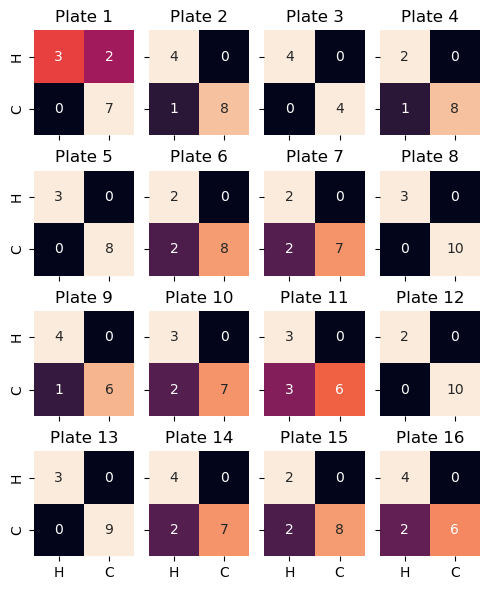

In [17]:
fig, axs = plt.subplots(4, 4, figsize=(5, 6), sharex=True, sharey=True)
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = pat_df[pat_df['plate'] == plate].groupby(
    #     ['group', 'pred'])['pat'].count().reset_index().pivot(index='group', columns='pred', values='pat')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = pat_df.reset_index()[pat_df.reset_index()['plate'] == plate].groupby(
        ['group', 'pred_group'])['pat'].count().reset_index().pivot(index='group', columns='pred_group', values='pat')
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

In [18]:
diag = pd.read_csv('meta/patient_diagnosis_groups.csv')
eval_df = eval_df.merge(diag, on='pat', how='left').set_index('pat')
eval_df

,Unnamed: 0,lab,pred,i,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4,plate,diag
pat,,,,,,,,,,,,,,,,,
H01,0,1,1.0,0,healthy,0.014652,0.015179,0.017831,0.018604,0.020785,0.768875,0.549111,-0.753672,-1.037950,-1.532192,NaN,NaN
H01,1,1,1.0,0,healthy,0.031948,0.026692,0.014412,0.011867,0.008880,1.548407,1.113585,-0.966570,-1.487609,-2.382663,NaN,NaN
H01,2,1,1.0,0,healthy,0.019385,0.023380,0.026837,0.028744,0.026370,1.048805,0.981071,-0.344847,-0.602909,-1.294210,NaN,NaN
H01,3,1,1.0,0,healthy,0.015654,0.010750,0.007971,0.007448,0.007792,0.835021,0.204133,-1.558809,-1.953353,-2.513297,NaN,NaN
H01,4,1,1.0,0,healthy,0.023645,0.027269,0.023897,0.021793,0.017529,1.247473,1.134955,-0.460874,-0.879754,-1.702598,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P74,2995,0,0.0,59,cancer,0.013206,0.014081,0.014792,0.014744,0.015163,-3.017519,-0.806678,-2.579883,-1.400585,-2.457827,16.0,Sarcoma-Rhabdomyosarcoma
P74,2996,0,0.0,59,cancer,0.023408,0.038576,0.026996,0.035016,0.028509,-2.445119,0.201131,-1.978268,-0.535657,-1.826454,16.0,Sarcoma-Rhabdomyosarcoma
P74,2997,0,0.0,59,cancer,0.005871,0.003958,0.005204,0.004555,0.005090,-3.828181,-2.075773,-3.624566,-2.575153,-3.549395,16.0,Sarcoma-Rhabdomyosarcoma


In [19]:
bag_df = eval_df.groupby(['pat', 'i'])[['pred', 'lab', 'group', 'plate', 'diag']].max()
bag_df['correct'] = bag_df['pred'] == bag_df['lab']
agg = bag_df.groupby(['pat', 'group'])['correct'].mean()
print(len(agg))
agg.reset_index()

172


,pat,group,correct
0,H01,healthy,0.2
1,H02,healthy,0.6
2,H03,healthy,1.0
3,H04,healthy,0.5
4,H05,healthy,0.9
...,...,...,...
167,P95,cancer,1.0
168,P96,cancer,1.0
169,P97,cancer,1.0
170,P98,cancer,1.0


In [20]:
bag_df.loc[bag_df['group'] == 'healthy', 'diag'] = 'healthy'

In [21]:
pat_df = bag_df.groupby(['plate', 'pat', 'group', 'diag'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()
pat_df.loc[pat_df['pred'] == 0, 'pred_group'] = 'C'
pat_df.loc[pat_df['pred'] == 1, 'pred_group'] = 'H'
pat_df['group'] = pat_df['group'].replace({'healthy' : 'H', 'cancer' : 'C'})
pat_df['group'] = pd.Categorical(values=pat_df['group'], categories=['H', 'C'])
pat_df['pred_group'] = pd.Categorical(values=pat_df['pred_group'], categories=['H', 'C'])
pat_df.set_index(['plate', 'pat', 'group'])

diag  pred pred_group
plate pat  group                                           
1.0   H01  H                       healthy   0.0          C
      H02  H                       healthy   1.0          H
      H03  H                       healthy   1.0          H
      H04  H                       healthy   0.0          C
      H05  H                       healthy   1.0          H
...                                    ...   ...        ...
16.0  P139 C      Sarcoma-Rhabdomyosarcoma   0.0          C
      P151 C      Sarcoma-Rhabdomyosarcoma   0.0          C
      P45  C                 Sarcoma-other   1.0          H
      P61  C         Sarcoma-Neuroblastoma   1.0          H
      P74  C      Sarcoma-Rhabdomyosarcoma   0.0          C

[181 rows x 3 columns]

In [22]:
pat_df[['plate', 'diag']].value_counts().reset_index().sort_values('plate')

,plate,diag,count
13,1.0,healthy,5
9,1.0,CNS-Glioma,7
2,2.0,CNS-Glioma,9
19,2.0,healthy,4
21,3.0,healthy,4
20,3.0,H&N cancer,4
6,4.0,H&N cancer,9
31,4.0,healthy,2
23,5.0,healthy,3
7,5.0,H&N cancer,8


In [23]:
diags = ['H&N cancer', 'Chordoma/Chondrosarcoma', 'CNS-Meningioma']
plates = [[3, 4, 5, 6], [10, 11, 12], [7, 8, 9]]

In [24]:
pat_df

,plate,pat,group,diag,pred,pred_group
0,1.0,H01,H,healthy,0.0,C
1,1.0,H02,H,healthy,1.0,H
2,1.0,H03,H,healthy,1.0,H
3,1.0,H04,H,healthy,0.0,C
4,1.0,H05,H,healthy,1.0,H
...,...,...,...,...,...,...
176,16.0,P139,C,Sarcoma-Rhabdomyosarcoma,0.0,C
177,16.0,P151,C,Sarcoma-Rhabdomyosarcoma,0.0,C
178,16.0,P45,C,Sarcoma-other,1.0,H
179,16.0,P61,C,Sarcoma-Neuroblastoma,1.0,H


/tmp/ipykernel_1338767/3382888285.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.reset_index()[pat_df.reset_index()['plate'].isin(ps) & ((pat_df.reset_index()['diag'] == d) | (pat_df.reset_index()['group'] == 'H'))].groupby(
/tmp/ipykernel_1338767/3382888285.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.reset_index()[pat_df.reset_index()['plate'].isin(ps) & ((pat_df.reset_index()['diag'] == d) | (pat_df.reset_index()['group'] == 'H'))].groupby(
/tmp/ipykernel_1338767/3382888285.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in 

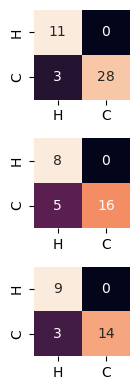

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(1.5, 4))
for ax, d, ps in zip(axs.flatten(), diags, plates):
    # mat = pat_df[pat_df['plate'] == plate].groupby(
    #     ['group', 'pred'])['pat'].count().reset_index().pivot(index='group', columns='pred', values='pat')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = pat_df.reset_index()[pat_df.reset_index()['plate'].isin(ps) & ((pat_df.reset_index()['diag'] == d) | (pat_df.reset_index()['group'] == 'H'))].groupby(
        ['group', 'pred_group'])['pat'].count().reset_index().pivot(index='group', columns='pred_group', values='pat')
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    # ax.set_title(f'{d} plates')
fig.tight_layout()

## Big model

In [27]:
name = '1_16_healthy_cancer_mil'
train_loader = healthy_vs_cancer_bagloader()
classifier = GatedAttention(branches=5)
loss_df = train_model(classifier, bag_loader=train_loader, 
                num_iter=50_000, lr=0.0001, device=device, fname=name, 
                save_model=True, seed=12341, plot=False,
                transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

iter: 49999; train loss: 0.06419863; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:15<00:00, 255.28it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_healthy_cancer_mil_model.pt


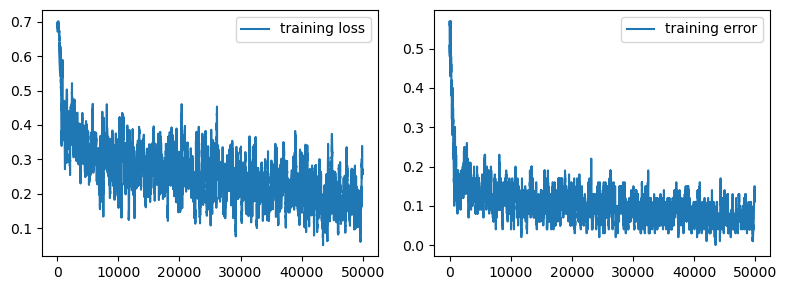

In [28]:
w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(loss_df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(loss_df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [29]:
name = '1_16_healthy_cancer_mil'
test_loader = test_healthy_vs_cancer_bagloader(return_masks=True)
res_df, zs, imgs, masks = eval_model(name, test_loader, return_masks=True) 
res_df

,lab,pred,i,pat,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4
0,1,1.0,0,H01,healthy,0.029606,0.022431,0.016807,0.030985,0.031323,-0.474155,1.612730,-1.836535,0.449414,0.269738
1,1,1.0,0,H01,healthy,0.014531,0.044111,0.004708,0.026703,0.025660,-1.185810,2.289002,-3.109024,0.300688,0.070326
2,1,1.0,0,H01,healthy,0.029733,0.009149,0.037679,0.018780,0.019966,-0.469871,0.715969,-1.029227,-0.051286,-0.180579
3,1,1.0,0,H01,healthy,0.006398,0.015124,0.004853,0.010465,0.008335,-2.006141,1.218580,-3.078748,-0.636097,-1.054164
4,1,1.0,0,H01,healthy,0.015051,0.031338,0.005330,0.024760,0.022850,-1.150689,1.947139,-2.984915,0.225150,-0.045653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42995,0,0.0,859,P99,cancer,0.002342,0.000821,0.004662,0.001540,0.001551,-4.197075,-1.716895,-4.799611,-3.184316,-3.495052
42996,0,0.0,859,P99,cancer,0.006741,0.002285,0.013435,0.004310,0.004270,-3.139748,-0.692882,-3.741197,-2.155372,-2.482270
42997,0,0.0,859,P99,cancer,0.010727,0.009576,0.015623,0.011221,0.010131,-2.675302,0.739786,-3.590303,-1.198457,-1.618222
42998,0,0.0,859,P99,cancer,0.005260,0.003500,0.009317,0.004866,0.004557,-3.387945,-0.266710,-4.107235,-2.033954,-2.417179


In [30]:
# res_df.to_csv(f'results/1_16_healthy_big_model.csv')

In [31]:
(res_df['pred'] == res_df['lab']).mean()
# 0.8989010989010989

0.9348837209302325

In [32]:
np.random.seed(1234)
vis_idx = np.concatenate([np.random.choice(np.argwhere((res_df['group'] == 'healthy').values).flatten(), replace=False, size=2500), 
                          np.random.choice(np.argwhere((res_df['group'] == 'cancer').values).flatten(), replace=False, size=2500)])
res_df[['umap_x', 'umap_y']] = np.nan
res_df.loc[vis_idx, ['umap_x', 'umap_y']] = umap.UMAP(random_state=123).fit_transform(np.array(zs)[vis_idx])

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


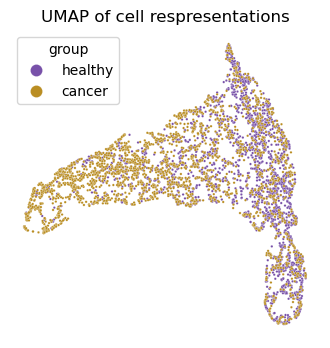

In [33]:
# res_df.loc[res_df['umap_y'] > 15, 'umap_y'] = np.nan
# res_df.loc[res_df['umap_y'] < -5, 'umap_y'] = np.nan
# res_df.loc[res_df['lab'] == 1, 'trajectory'] = 'up'
# res_df.loc[res_df['lab'] == 0, 'trajectory'] = 'low'

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue='group', s=3, ax=ax, palette={'healthy' : '#7851A9', 'cancer' : '#BA8E23'})
ax.set_title('UMAP of cell respresentations')
sns.move_legend(ax, 'best', markerscale=5)
ax.axis('off');

In [34]:
res_df['total attention'] = res_df['attention 0'] + res_df['attention 1'] + res_df['attention 2'] + res_df['attention 3']  +res_df['attention 4']
res_df

,lab,pred,i,pat,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4,umap_x,umap_y,total attention
0,1,1.0,0,H01,healthy,0.029606,0.022431,0.016807,0.030985,0.031323,-0.474155,1.612730,-1.836535,0.449414,0.269738,NaN,NaN,0.131151
1,1,1.0,0,H01,healthy,0.014531,0.044111,0.004708,0.026703,0.025660,-1.185810,2.289002,-3.109024,0.300688,0.070326,10.308898,7.974058,0.115714
2,1,1.0,0,H01,healthy,0.029733,0.009149,0.037679,0.018780,0.019966,-0.469871,0.715969,-1.029227,-0.051286,-0.180579,10.602844,4.398914,0.115307
3,1,1.0,0,H01,healthy,0.006398,0.015124,0.004853,0.010465,0.008335,-2.006141,1.218580,-3.078748,-0.636097,-1.054164,NaN,NaN,0.045174
4,1,1.0,0,H01,healthy,0.015051,0.031338,0.005330,0.024760,0.022850,-1.150689,1.947139,-2.984915,0.225150,-0.045653,NaN,NaN,0.099330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42995,0,0.0,859,P99,cancer,0.002342,0.000821,0.004662,0.001540,0.001551,-4.197075,-1.716895,-4.799611,-3.184316,-3.495052,NaN,NaN,0.010916
42996,0,0.0,859,P99,cancer,0.006741,0.002285,0.013435,0.004310,0.004270,-3.139748,-0.692882,-3.741197,-2.155372,-2.482270,NaN,NaN,0.031042
42997,0,0.0,859,P99,cancer,0.010727,0.009576,0.015623,0.011221,0.010131,-2.675302,0.739786,-3.590303,-1.198457,-1.618222,NaN,NaN,0.057278
42998,0,0.0,859,P99,cancer,0.005260,0.003500,0.009317,0.004866,0.004557,-3.387945,-0.266710,-4.107235,-2.033954,-2.417179,NaN,NaN,0.027500


In [35]:
correct_h_bags = res_df[(res_df['lab'] == res_df['pred']) & (res_df['group'] == 'healthy')]['i'].unique()
correct_h_bags

array([  0,   1,   2,   5,   6,   7,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  91,  92,  93,  94,  95,  96,  97,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174])

In [36]:
correct_c_bags = res_df[(res_df['lab'] == res_df['pred']) & (res_df['group'] == 'cancer')]['i'].unique()
correct_c_bags

array([175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
       241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 262, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
       309, 311, 312, 313, 314, 315, 316, 317, 318, 319, 323, 325, 326,
       327, 328, 329, 330, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 365, 366, 368, 369, 370, 371, 37

In [43]:
img_array = np.array(imgs).reshape((860, 50, 1, 28, 28))
img_array.shape

(860, 50, 1, 28, 28)

In [44]:
mask_array = np.array(masks).reshape((860, 50, 1, 28, 28))
mask_array.shape

(860, 50, 1, 28, 28)

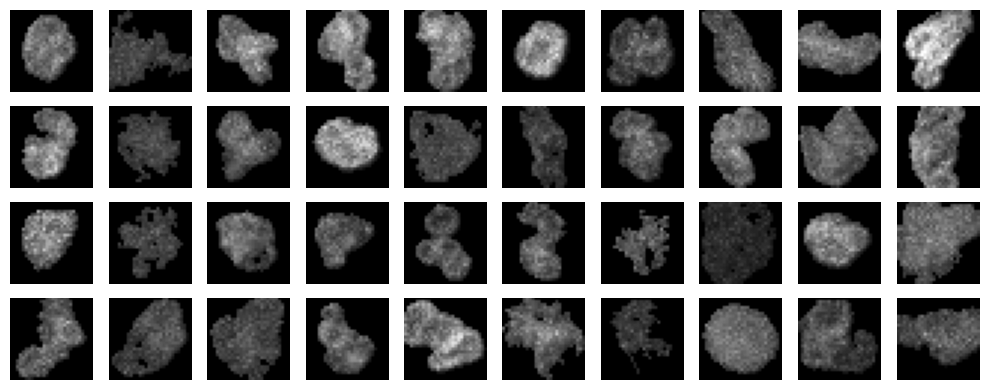

In [45]:
top_h_imgs = []
top_h_masks = []
for i in correct_h_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_h_imgs.extend(img_array[i, idx])
    top_h_masks.extend(mask_array[i, idx])
top_h_imgs = np.array(top_h_imgs)
top_h_masks = np.array(top_h_masks)

np.random.seed(25323)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_idx = np.random.choice(np.arange(len(top_h_imgs)), replace=False, size=40)
show_imgs = top_h_imgs[np.random.choice(np.arange(len(top_h_imgs)), replace=False, size=40)]
for im, m, ax in zip(top_h_imgs[show_idx], top_h_masks[show_idx], axxs.flatten()):
    ax.imshow((im * m).squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

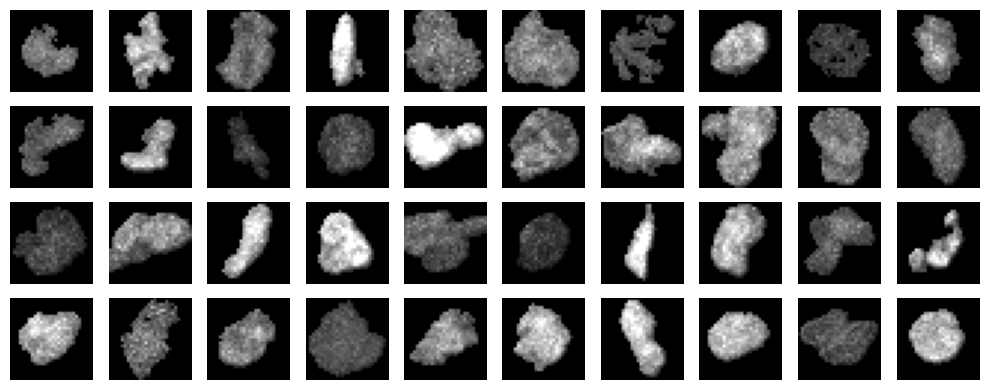

In [46]:
top_c_imgs = []
top_c_masks = []
for i in correct_c_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_c_imgs.extend(img_array[i, idx])
    top_c_masks.extend(mask_array[i, idx])
top_c_imgs = np.array(top_c_imgs)
top_c_masks = np.array(top_c_masks)

np.random.seed(5123)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_idx = np.random.choice(np.arange(len(top_c_imgs)), replace=False, size=40)
for im, m, ax in zip(top_c_imgs[show_idx], top_c_masks[show_idx], axxs.flatten()):
    ax.imshow((im * m).squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()